# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**.

First, the needed imports.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.8.0+cu129  Device: cuda


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [2]:
batch_size = 32

train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data',
                                    train=False,
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model.

In [6]:
# Alteração da função de treino para receber o modelo e otimizador como parâmetros
def train(model,optimizer,epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
# Alteração da função de validação para receber o modelo como parâmetro
def validate(model,loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`.

In [8]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model,optimizer,epoch)
    validate(model,lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329116
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.024082
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.423733
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.795465
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.692660
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.617097
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.565931
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.616720
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.575800
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.554893

Validation set: Average loss: 0.3604, Accuracy: 8969/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.543870
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.514117
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.533909
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.476538
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.485329
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.234806
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.344255
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.383205
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.12

Let's now visualize how the training progressed.

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

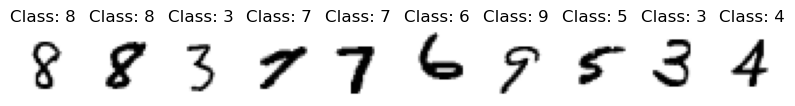

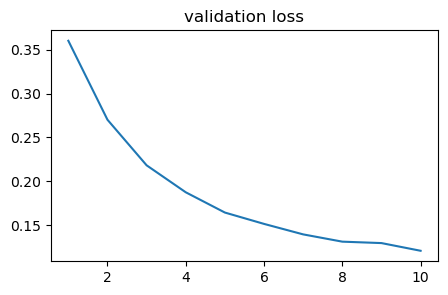

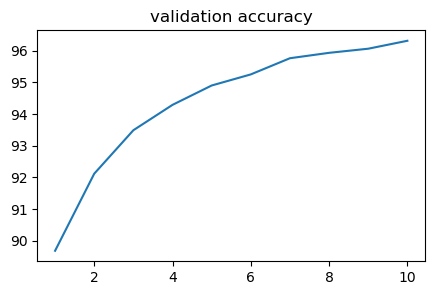

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')
plt.show()

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy


## Proposta Modelo 1

In [10]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Camada de normalização
        self.norm = nn.BatchNorm2d(1)
        # Aplica Zero Padding --> Colocando 0's nas bordas da imagem
        self.pad = nn.ZeroPad2d(1)
        self.fc1 = nn.Linear((28+2)*(28+2), 50) # Aumenta linha e coluna por causa do padding
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # Garante formato [batch_size, C, H, W] com C=1 --> devido ao BatchNorm2d
        if x.dim() == 3:            # [batch_size, H, W]
            x = x.unsqueeze(1)      # [batch_size, 1, H, W]
        # Aplica o padding
        x = self.pad(x)             # [batch_size, 1, 30, 30]
        # Aplica a normalização
        x = self.norm(x)
        # Continua o mesmo processo
        x = torch.flatten(x, 1)     # [batch_size, 30*30] --> Mesma coisa que x.view(-1, 30*30)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

model1 = Net1().to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model1)

Net1(
  (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pad): ZeroPad2d((1, 1, 1, 1))
  (fc1): Linear(in_features=900, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [11]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model1,optimizer1,epoch)
    validate(model1,lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311732
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.574511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.886172
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.247829
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.279294
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.236758
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.261879
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.555884
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.297161
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.171264

Validation set: Average loss: 0.1924, Accuracy: 9406/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.388951
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.353847
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.165521
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.371644
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.197301
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.285641
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.090287
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.097960
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.11

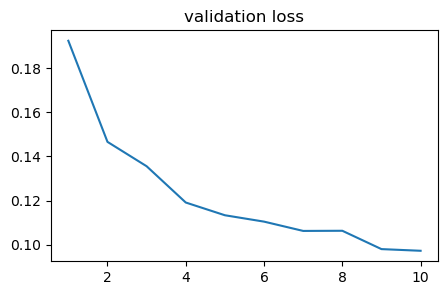

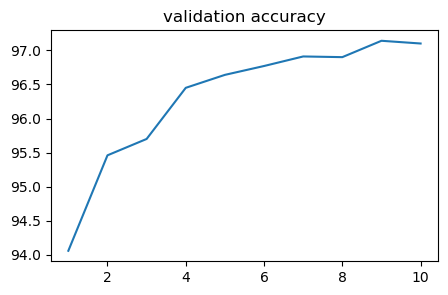

In [12]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')
plt.show()

## Proposta Modelo 2

In [13]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Criar mais camadas e com mais neurônios
        self.fc1 = nn.Linear(28*28, (28*28)//2)
        self.fc1_drop = nn.Dropout(0.2)
        # Divide novamente por 2 o número de neurônios com base no tamanho da imagem
        self.fc2 = nn.Linear((28*28)//2, (28*28)//4)
        self.fc2_drop = nn.Dropout(0.2)
        # Volta para estrutura anterior
        self.fc3 = nn.Linear((28*28)//4, 50)
        self.fc3_drop = nn.Dropout(0.2)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.relu(self.fc3(x))
        x = self.fc3_drop(x)
        return F.log_softmax(self.fc4(x), dim=1)

model2 = Net2().to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model2)

Net2(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=392, out_features=196, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=196, out_features=50, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)


In [14]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model2,optimizer2,epoch)
    validate(model2,lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307171
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.266817
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.166111
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.543718
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.994174
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.585435
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.530072
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.563796
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.288804
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.455918

Validation set: Average loss: 0.3625, Accuracy: 8943/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.408852
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.570961
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.385925
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.205977
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.477877
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.260614
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.338440
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.395252
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.17

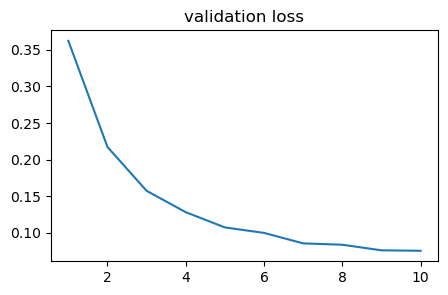

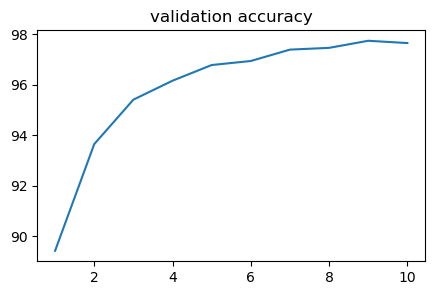

In [15]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')
plt.show()

## Modelo 3

In [28]:
class MLP98(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 784)
        self.bn1 = nn.BatchNorm1d(784)
        self.drop1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(784, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(128, 10)  # CrossEntropyLoss inclui Softmax


    def forward(self, x):
        x = x.view(x.size(0), -1)      # [N, 784]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop3(x)
        return self.fc4(x)   

model3 = MLP98().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, 
                              weight_decay=1e-4)  # Penalização L2
criterion = nn.CrossEntropyLoss()
print(model3)

MLP98(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (bn1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=784, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [29]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model3,optimizer3,epoch)
    validate(model3,lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.506402
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.376484
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.115439
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.233738
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.081443
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.123063
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.152631
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.482004
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.184087
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.202559

Validation set: Average loss: 0.1024, Accuracy: 9675/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.151440
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.053547
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.040099
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.087407
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.238374
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.019670
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.250689
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.127026
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.03

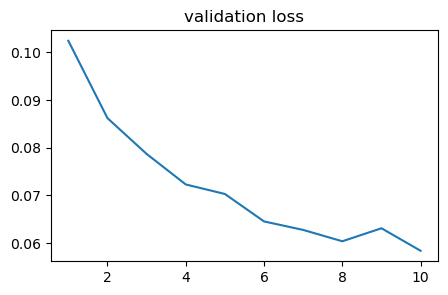

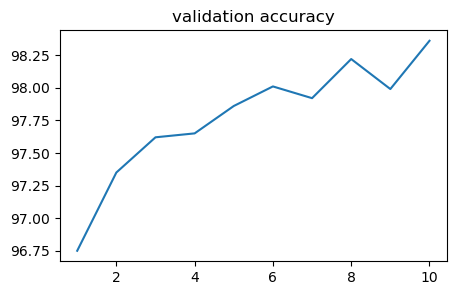

In [30]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')
plt.show()